# CS 7641 Homework 1 - Fall 2020



Refs: 
- https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
- https://www.kaggle.com/arunmohan003/pruning-decision-trees
- https://www.dataquest.io/blog/learning-curves-machine-learning/

In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, svm, datasets, metrics
from sklearn.model_selection import train_test_split,StratifiedKFold, ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from utilities import plot_2d_data, plot_2d_classifier, plot_confusionmatrix
from utilities import learning_curve_model, validation_curve_model, plot_learning_curve
from scipy import stats
import seaborn as sns
import os

from utilities import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

## Loading Datasets

In [36]:
data = pd.read_csv("./data/heart.csv")
target_names=['Disease', 'No Disease']
data.shape

(303, 14)

In [37]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [38]:
correlation = data.corr()
correlation

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


<AxesSubplot:>

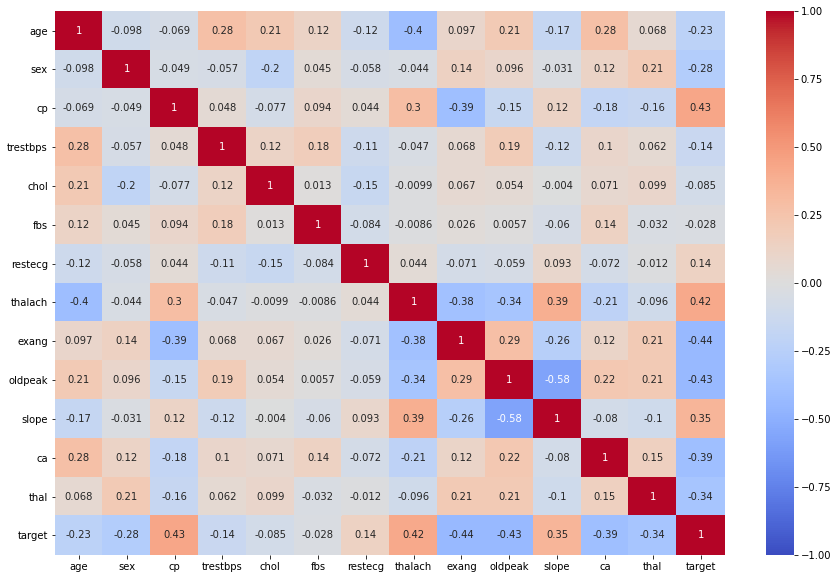

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

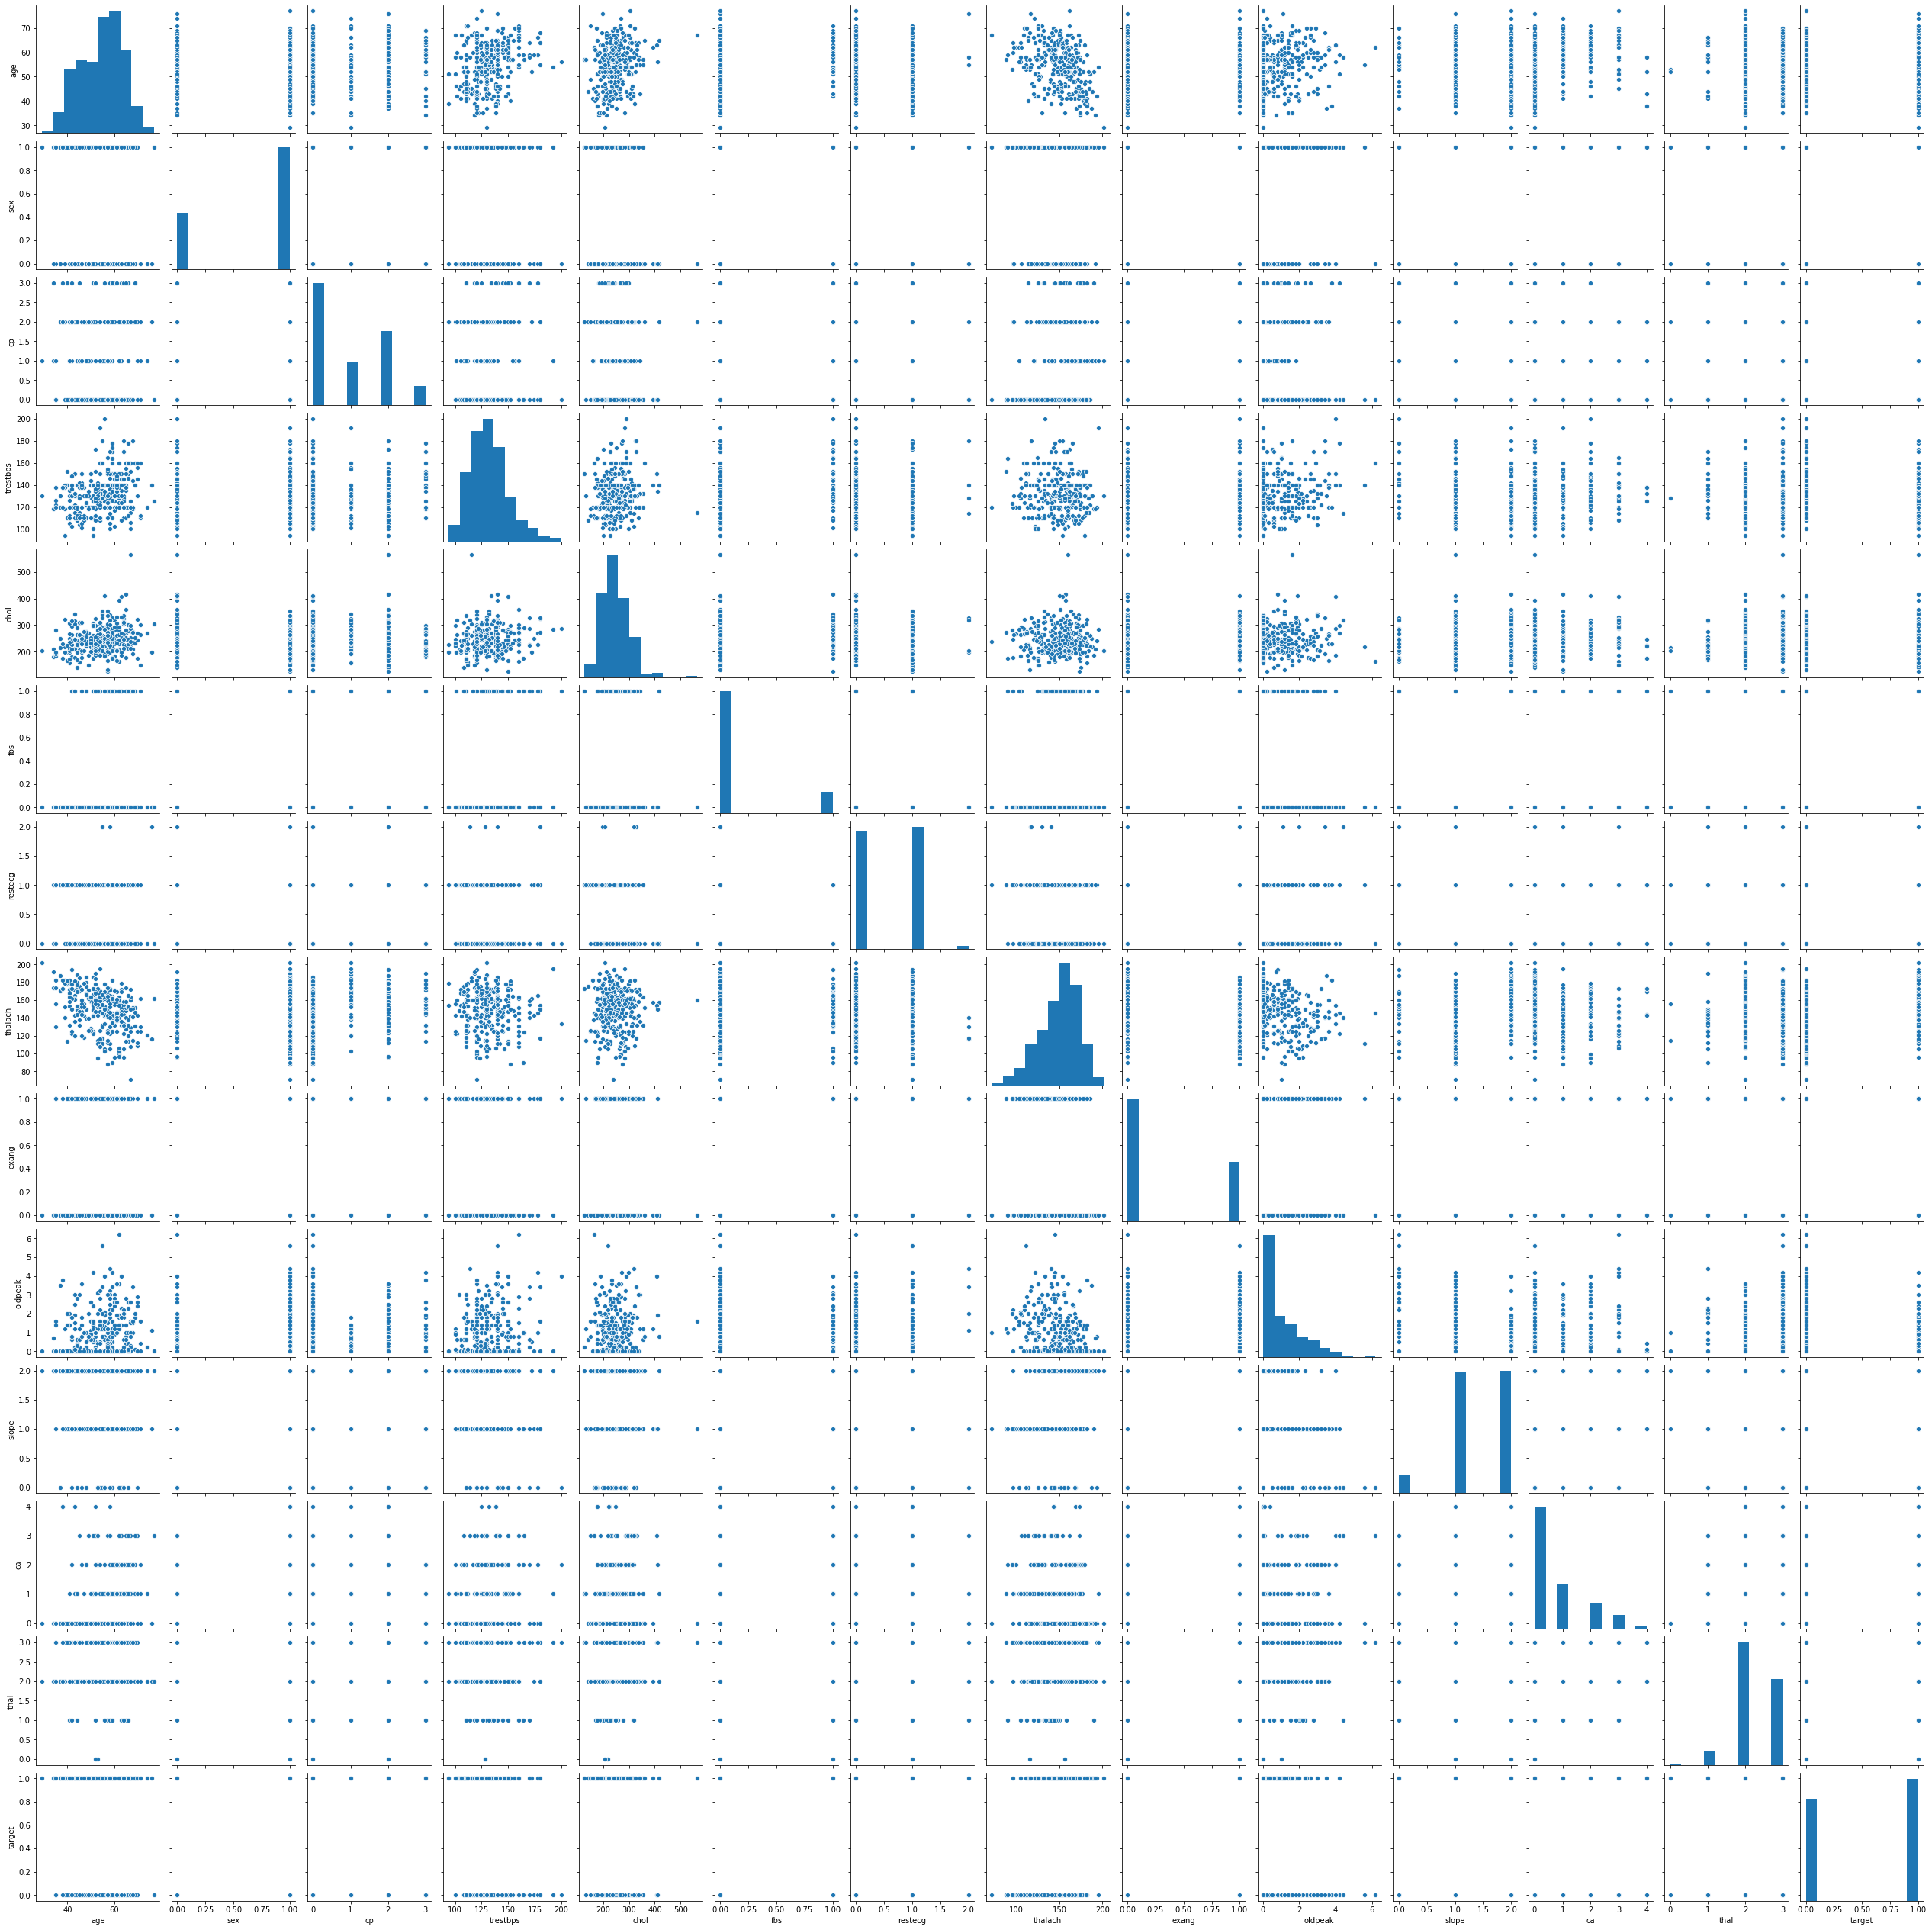

In [40]:
sns.pairplot(data)

In [41]:
data_X = data.drop(columns = ['cp', 'thal', 'slope', 'target'], axis=1)/256
data_y = data.target

data_X = (data_X - np.min(data_X)) / (np.max(data_X) - np.min(data_X)).values

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=100)

In [42]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

## Decision Tree

In [43]:
# https://scikit-learn.org/stable/modules/tree.html
# https://deepstat.tistory.com/44
# https://jcabelloc.github.io/machine%20learning/2019/02/27/classification-task.html

dtc = tree.DecisionTreeClassifier(random_state=100)
dtc.fit(train_X, train_y)

DecisionTreeClassifier(random_state=100)

<module 'matplotlib.pyplot' from '/Users/worthylafollette/dev/gatech/venv/ml/ml/lib/python3.8/site-packages/matplotlib/pyplot.py'>

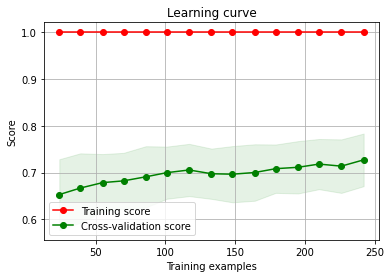

In [44]:
train_size=np.linspace(.1, 1.0, 15)
learning_curve_model(data_X, data_y, dtc, cv, train_size)

In [45]:
predict_y_train = dtc.predict(train_X)
predict_y = dtc.predict(test_X)
print(f"Training accuracy score: {100* accuracy_score(train_y, predict_y_train)}%")
print(f"Testing accuracy Score: {100* accuracy_score(test_y, predict_y)}%")

Training accuracy score: 100.0%
Testing accuracy Score: 73.77049180327869%


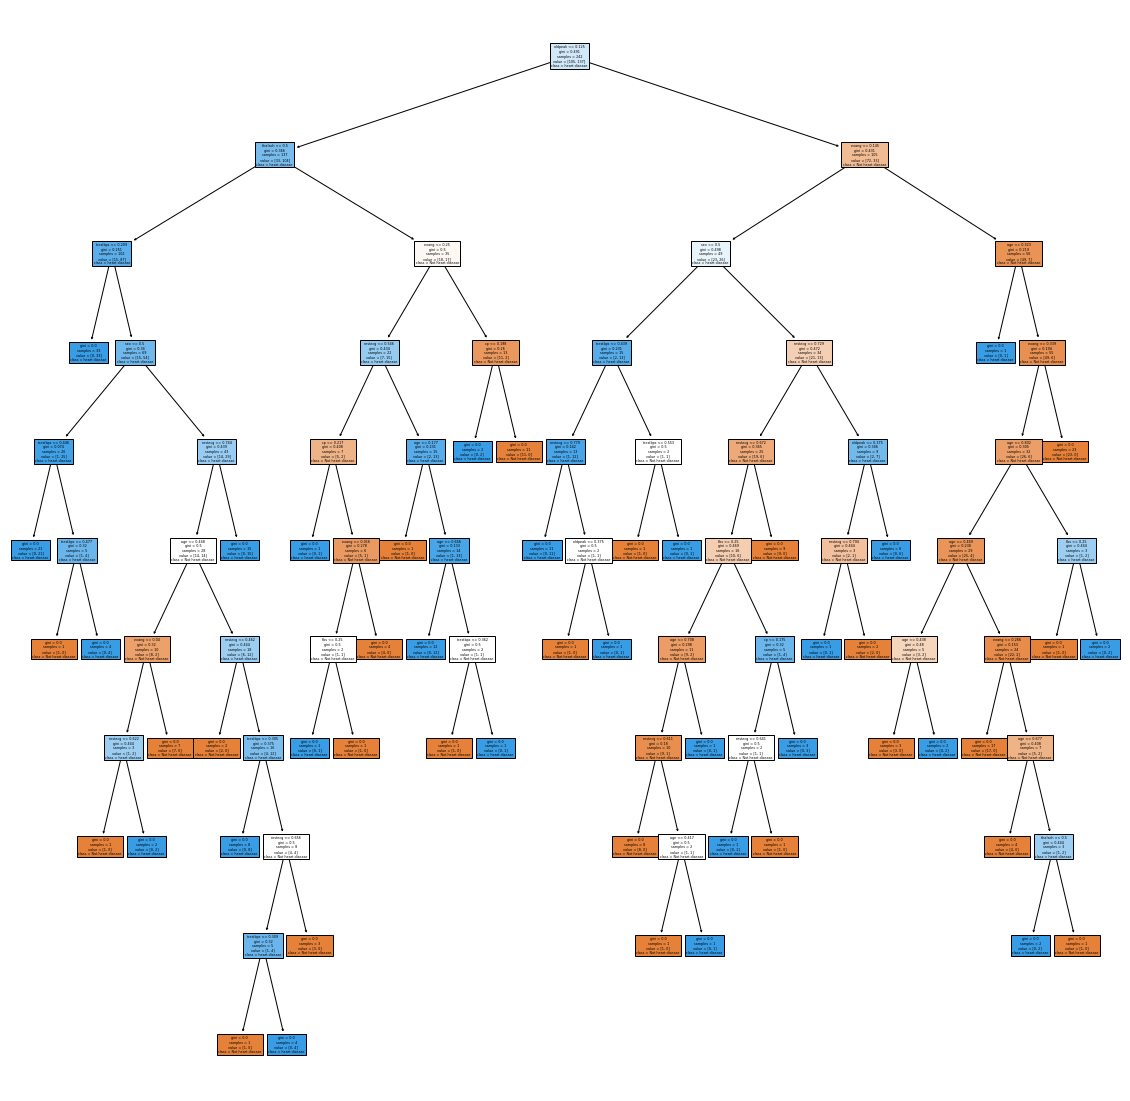

In [46]:
plt.figure(figsize=(20,20))
features = data.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(dtc,feature_names=features,class_names=classes,filled=True)
plt.show()

### Decision Tree with Pre-prunning

In [47]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(train_X,train_y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [48]:
model = gcv.best_estimator_
model.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=3)

<module 'matplotlib.pyplot' from '/Users/worthylafollette/dev/gatech/venv/ml/ml/lib/python3.8/site-packages/matplotlib/pyplot.py'>

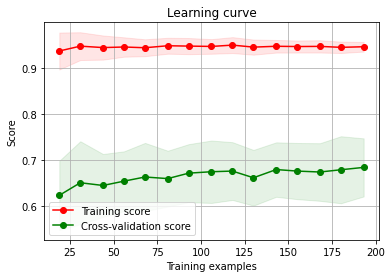

In [49]:
train_size=np.linspace(.1, 1.0, 15)
learning_curve_model(train_X, train_y, model, cv, train_size)

In [50]:
y_train_pred = model.predict(train_X)
y_test_pred = model.predict(test_X)

print(f'Train score {accuracy_score(y_train_pred,train_y)}')
print(f'Test score {accuracy_score(y_test_pred,test_y)}')

Train score 0.9380165289256198
Test score 0.8524590163934426


Train Confusion matrix


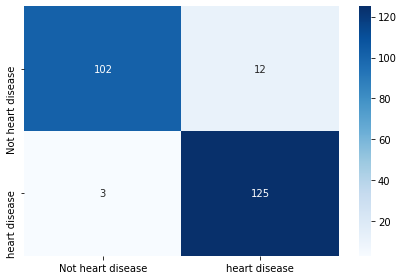

Test Confusion matrix


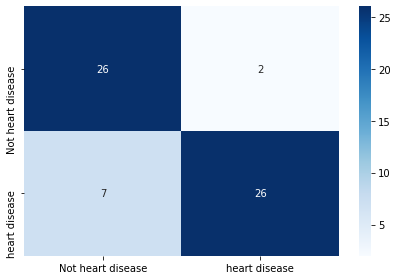

In [51]:
plot_confusionmatrix(y_train_pred,train_y,classes, 'Train')
plot_confusionmatrix(y_test_pred,test_y,classes, 'Test')

### Decision Tree - post Pruning

In [52]:
path = clf.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00330579 0.00344353 0.00358127 0.00371901 0.00378788
 0.00383707 0.0039733  0.00491932 0.00550964 0.00550964 0.00550964
 0.00550964 0.00550964 0.00587904 0.00608565 0.00644252 0.00665092
 0.00734619 0.0077135  0.00826446 0.00826446 0.00877536 0.01157025
 0.01331258 0.01331289 0.01398601 0.01581699 0.01882498 0.02017633
 0.02904231 0.03553297 0.0972106 ]


In [53]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_X, train_y)
    clfs.append(clf)

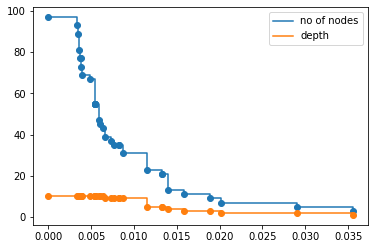

In [54]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

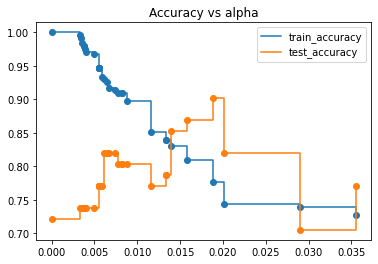

In [55]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(train_X)
    y_test_pred = c.predict(test_X)
    train_acc.append(accuracy_score(y_train_pred,train_y))
    test_acc.append(accuracy_score(y_test_pred,test_y))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [56]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.018)
clf_.fit(train_X,train_y)

DecisionTreeClassifier(ccp_alpha=0.018, random_state=0)

<module 'matplotlib.pyplot' from '/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/matplotlib/pyplot.py'>

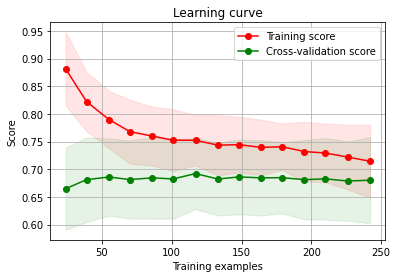

In [131]:
train_size=np.linspace(.1, 1.0, 15)
learning_curve_model(train_X, train_y, clf, cv, train_size)

Train score 0.8099173553719008
Test score 0.8688524590163934
Train Confusion matrix


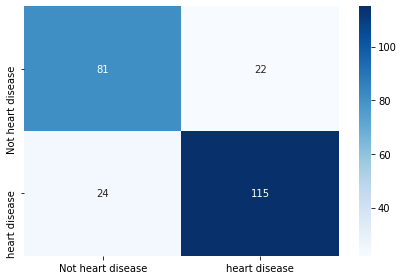

Test Confusion matrix


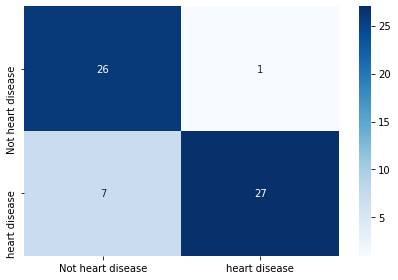

In [132]:
y_train_pred = clf_.predict(train_X)
y_test_pred = clf_.predict(test_X)

print(f'Train score {accuracy_score(y_train_pred,train_y)}')
print(f'Test score {accuracy_score(y_test_pred,test_y)}')
plot_confusionmatrix(y_train_pred,train_y,classes, 'Train')
plot_confusionmatrix(y_test_pred,test_y,classes, 'Test')

## Neural Network

In [57]:
model = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000, random_state=18)
model.fit(train_X, train_y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5,), max_iter=2000,
              random_state=18, solver='lbfgs')

In [58]:
predicted = model.predict(test_X)

In [59]:
print("Classification Report:\n %s:" % (metrics.classification_report(test_y, predicted, target_names=target_names)))

Classification Report:
               precision    recall  f1-score   support

     Disease       0.96      0.79      0.87        33
  No Disease       0.79      0.96      0.87        28

    accuracy                           0.87        61
   macro avg       0.88      0.88      0.87        61
weighted avg       0.89      0.87      0.87        61
:


Training Sizes: [ 19  62 106 149 193]
Trainind Scores: [[1.         1.         1.         1.         1.        ]
 [0.93548387 0.88709677 0.90322581 0.90322581 0.90322581]
 [0.97169811 0.86792453 0.8490566  0.85849057 0.85849057]
 [0.9261745  0.93288591 0.86577181 0.80536913 0.91275168]
 [0.83419689 0.84974093 0.86010363 0.87564767 0.89637306]]
Test Scores: [[0.63265306 0.75510204 0.6875     0.6875     0.79166667]
 [0.81632653 0.7755102  0.72916667 0.66666667 0.70833333]
 [0.65306122 0.73469388 0.66666667 0.77083333 0.77083333]
 [0.67346939 0.71428571 0.77083333 0.77083333 0.72916667]
 [0.81632653 0.75510204 0.79166667 0.8125     0.70833333]]


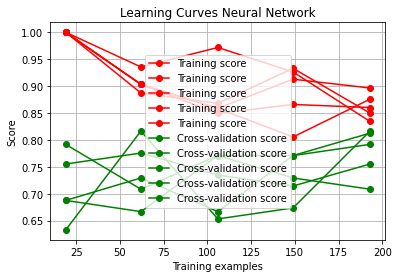

In [61]:
# https://stackoverflow.com/questions/35910905/very-low-test-score-result-in-sklearn-diabetes-dataset-on-plotting-the-learning/35925068#35925068
title = "Learning Curves Neural Network"
plt.figure(1)
plt.title(title)
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(model, train_X, train_y)

print(f'Training Sizes: {train_sizes}')
print(f'Trainind Scores: {train_scores}')
print(f'Test Scores: {test_scores}')

plt.grid()
plt.plot(train_sizes, train_scores, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores, 'o-', color="g",label="Cross-validation score")

plt.legend(loc="best")

plt.show()

In [84]:
mlp = MLPClassifier(max_iter=5000, random_state=18)
param_list = {"hidden_layer_sizes": [(1,),(5,),(10,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00001, 0.00005,0.0005]}

gcv = GridSearchCV(estimator=mlp, param_grid=param_list)
gcv.fit(train_X, train_y)

GridSearchCV(estimator=MLPClassifier(max_iter=5000, random_state=18),
             param_grid={'alpha': [1e-05, 5e-05, 0.0005],
                         'hidden_layer_sizes': [(1,), (5,), (10,)],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [85]:
print(classification_report(gcv.best_estimator_.predict(test_X), test_y))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [86]:
print('Best parameters found:\n', gcv.best_params_, gcv.best_score_)

Best parameters found:
 {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'adam'} 0.7890306122448979


In [87]:
# All results
means = gcv.cv_results_['mean_test_score']
stds = gcv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gcv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.752 (+/-0.093) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.566 (+/-0.009) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.669 (+/-0.191) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'adam'}
0.781 (+/-0.050) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'lbfgs'}
0.608 (+/-0.163) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'sgd'}
0.789 (+/-0.064) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'adam'}
0.752 (+/-0.066) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}
0.694 (+/-0.149) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
0.768 (+/-0.043) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'adam'}
0.752 (+/-0.090) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.566 (+/-0.009) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.669 (+/-0.191) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver

## Boosting

In [88]:
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))
stump = DecisionTreeClassifier(max_depth=1, random_state = 100)
 
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, 
                                   n_estimators=10, learning_rate=rate)
        model.fit(train_X.values[trn, :], train_y.values[trn])
        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], model.predict(train_X.values[val, :]))
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)
print(f'Training Error {trn_err}, Value Error {val_err}')

Training Error [0.21945842 0.20936668 0.19927705 0.19191857 0.19284869 0.17860948
 0.17723967 0.1698812  0.16986852 0.17355727], Value Error [0.25966667 0.2645     0.2485     0.23083333 0.21083333 0.2185
 0.21916667 0.23516667 0.22633333 0.20233333]


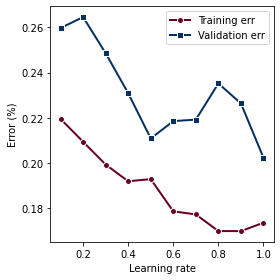

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Training err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [90]:
n_estimator_steps, n_folds = 2, 10
number_of_stumps = np.arange(2, 40, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(train_X.values[trn, :], train_y.values[trn])

        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], 
                                           model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], 
                                           model.predict(train_X.values[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

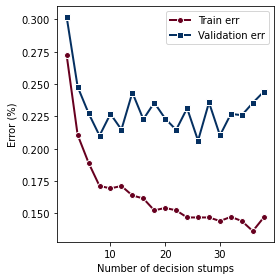

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [92]:
shallow_tree = DecisionTreeClassifier(max_depth=1)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                                  n_estimators=18, learning_rate=0.8)
ensemble.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=18)

In [93]:
ypred = ensemble.predict(test_X)
acc = accuracy_score(test_y, ypred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 86.89%


## SVM

In [94]:
model = svm.SVC(kernel='rbf', C=30, gamma='auto')
model.fit(train_X, train_y)
print(f'{model.score(test_X, test_y)*100:.2f}%')

86.89%


In [95]:
from sklearn.model_selection import cross_val_score

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report

# https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

# model_OVRC = OneVsRestClassifier(svm.LinearSVC(class_weight='balanced', max_iter=10000))
# svm_model = svm.LinearSVC(class_weight='balanced', max_iter=100000)
svm_model = svm.SVC()

parameters = {'C':(0.1, 0.5, 1, 2, 5, 10, 20, 40, 100), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')
         }

model = GridSearchCV(svm_model, parameters, cv=5)

model.fit(train_X, train_y)
model_predict = model.predict(test_X)

model.cv_results_
print(f'Best Score: {model.best_score_}, / Best parameters: {model.best_params_}')

Best Score: 0.8224489795918368, / Best parameters: {'C': 5, 'gamma': 1, 'kernel': 'poly'}


In [97]:
print(classification_report(test_y, model_predict))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83        33
           1       0.76      0.93      0.84        28

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



## KNN

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [107]:
KNN_Model = KNeighborsClassifier(n_neighbors=6).fit(train_X, train_y)

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

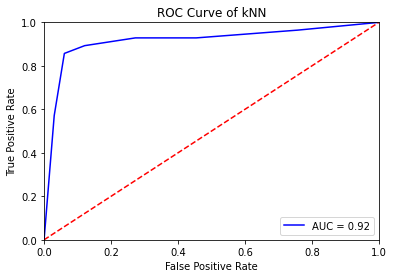

In [108]:
y_scores = KNN_Model.predict_proba(test_X)
fpr, tpr, threshold = roc_curve(test_y, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [109]:
print(f'8 NN Score: {KNN_Model.score(test_X, test_y)*100:.2f}%')

8 NN Score: 88.52%


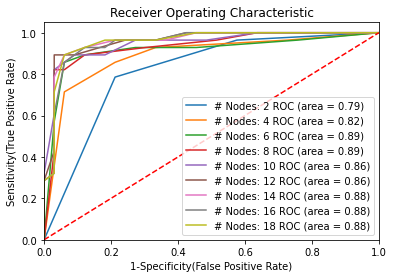

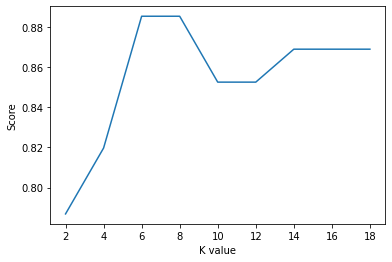

Maximum KNN Score is 88.52%


In [125]:
# try to find best k value
scoreList = []
for i in range(2,20,2):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(train_X, train_y)
    fpr, tpr, thresholds = metrics.roc_curve(test_y, knn2.predict_proba(test_X)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(test_y,knn2.predict(test_X))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (f'# Nodes: {i}', auc))
    scoreList.append(knn2.score(test_X, test_y))
    # Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display
    
    
plt.plot(range(2,20,2), scoreList)
plt.xticks(np.arange(2,20,2))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
print(f'Maximum KNN Accuracy is {acc:.2f}%')